In [1]:
# import packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import idx2numpy
import os
import pickle
from PIL import Image

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
from torchsummary import summary

In [2]:
# Define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Define a methor to load cifar10
def load_batch(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    X = data[b'data']
    Y = data[b'labels']
    X = X.reshape(-1, 3, 32, 32)
    X = X.astype('float32') / 255.0
    Y = np.array(Y)
    return X, Y

In [4]:
# Load the training set
X_train = []
y_train = []
for i in range(1, 6):
    filename = '../datasets/cifar-10-batches-py/data_batch_' + str(i)
    X, y = load_batch(filename)
    X_train.append(X)
    y_train.append(y)
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Load the test set
X_test, y_test = load_batch('../datasets/cifar-10-batches-py/test_batch')

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 3, 32, 32) (50000,) (10000, 3, 32, 32) (10000,)


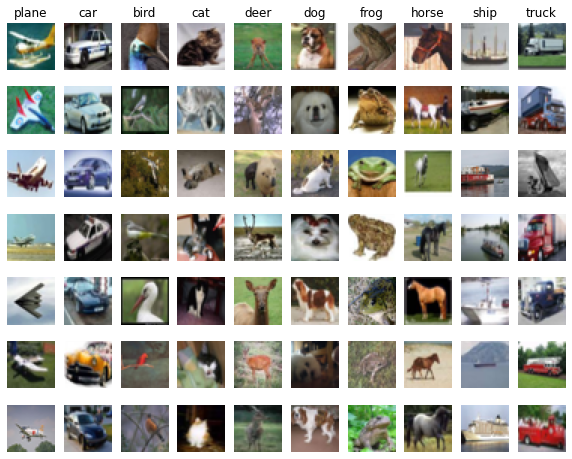

In [5]:
# We show a few examples of training images from each class.
plt.rcParams['figure.figsize'] = (10.0, 8.0)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 7

def visualize_data(dataset, classes, samples_per_class):
    num_classes = len(classes)
    for y, cls in enumerate(classes):
      idxs = np.flatnonzero(y_train == y)
      idxs = np.random.choice(idxs, samples_per_class, replace=False)
      for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(dataset[idx])
        plt.axis('off')
        if i == 0:
          plt.title(cls)
    plt.show()

visualize_data(X_train.transpose(0, 2, 3, 1), classes, samples_per_class)

In [6]:
# Define the rotation function
def img_rotate(img, deg=1):
    img1 = np.transpose(img, (1, 2, 0))
    img1 = np.rot90(img1, deg)
    return np.transpose(img1, (2, 0, 1))

In [7]:
# Expand X_train and y_train
X_train_all = []
y_train_all = []

for (x, y) in zip(X_train, y_train):
    X_train_all.append(x)
    X_train_all.append(img_rotate(x))
    X_train_all.append(img_rotate(x, 2))
    X_train_all.append(img_rotate(x, 3))

    for i in range(4):
        y_train_all.append((y, i))


In [8]:
X_train_all = torch.Tensor(np.array(X_train_all, dtype=np.float32))
y_train_all = torch.Tensor(np.array(y_train_all, dtype=np.int64))

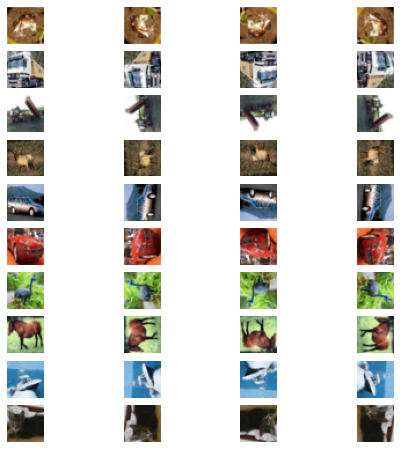

tensor([[6., 0.],
        [6., 1.],
        [6., 2.],
        [6., 3.],
        [9., 0.],
        [9., 1.],
        [9., 2.],
        [9., 3.],
        [9., 0.],
        [9., 1.],
        [9., 2.],
        [9., 3.],
        [4., 0.],
        [4., 1.],
        [4., 2.],
        [4., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [2., 0.],
        [2., 1.],
        [2., 2.],
        [2., 3.],
        [7., 0.],
        [7., 1.],
        [7., 2.],
        [7., 3.],
        [8., 0.],
        [8., 1.],
        [8., 2.],
        [8., 3.],
        [3., 0.],
        [3., 1.],
        [3., 2.],
        [3., 3.]])


In [9]:
# Display 40 images from X_train_all
fig, axs = plt.subplots(10, 4, figsize=(8, 8))
for i in range(10):
    for j in range(4):
        axs[i, j].imshow(np.transpose(X_train_all[i*4+j], (1, 2, 0)))
        axs[i, j].axis("off")
plt.show()
print(y_train_all[:40])

### Data augmentation

In [10]:
# Define a data augmentation method
def data_augmentation(img, num_img=2):
    # Add 4 pixels of padding on each side
    padded_img = np.pad(img, ((0, 0), (4, 4), (4, 4)), mode='constant', constant_values=0)
    
    # Randomly crop some 32x32 images from the padded image
    cropped_img = []
    for _ in range(num_img):
        x = np.random.randint(0, 8)
        y = np.random.randint(0, 8)
        cropped_img.append(padded_img[:, x:x+32, y:y+32])
        
    return cropped_img

In [11]:
new_images = []

for i in X_train:
    new_images.extend(data_augmentation(i, 1))

X_train_new = np.concatenate([X_train, np.array(new_images)], axis=0)
y_train_new = np.concatenate([y_train, y_train], axis=0)

print(X_train_new.shape)
print(y_train_new.shape)

(100000, 3, 32, 32)
(100000,)


In [12]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, num_block=1):
        super(ResBlock, self).__init__()
        self.num_block = num_block
        self.layers = nn.ModuleList([])
        
        self.layers.append(nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride)
        ))
        self.layers.append(nn.Sequential  (
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=stride),
#             nn.GroupNorm(out_channel//4, out_channel),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
            nn.GroupNorm(out_channel//4, out_channel),
            nn.ReLU(inplace=True)
        ))
        
        for _ in range(1, num_block):
            self.layers.append(nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size=1, stride=1)
            ))
            self.layers.append(nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
#                 nn.GroupNorm(out_channel//4, out_channel),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
#                 nn.GroupNorm(out_channel//4, out_channel),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            ))
    
    def forward(self, x):
        for i in range(self.num_block):
            x_identity = self.layers[2*i](x)
            x = self.layers[2*i+1](x)
            x = F.relu(x + x_identity, inplace=True) 
        
        return x
    

class JointResNet(nn.Module):
    def __init__(self):
        super(JointResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
#         self.gn1 = nn.GroupNorm(4, 16)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.layers1 = ResBlock(16, 16, num_block=4)
        self.layers2 = ResBlock(16, 32, stride=2, num_block=4)
        self.layers3_1 = ResBlock(32, 64, stride=2, num_block=4)
        self.layers3_2 = ResBlock(32, 64, stride=2, num_block=4)
        
        self.avgpool1 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 10)
        
        self.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc2 = nn.Linear(64, 4)
        
        
    def forward(self, x):
        x = self.conv1(x)
#         x = self.gn1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.layers1(x)
        x = self.layers2(x)
        
        x1 = self.layers3_1(x)
        x1 = self.avgpool1(x1)
        x1 = x1.view(-1, 64)
        x1 = self.fc1(x1)
        
        x2 = self.layers3_2(x)
        x2 = self.avgpool2(x2)
        x2 = x2.view(-1, 64)
        x2 = self.fc2(x2)
        return x1, x2  
    

# Define my dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Image classification test

In [23]:
# Set up the data loaders
train_loader = torch.utils.data.DataLoader(MyDataset(X_train_new, y_train_new), batch_size=128, shuffle=True)

# Define the loss functions
criterion = nn.CrossEntropyLoss()

# Initialize the model and define optimizer
model = JointResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]             272
            Conv2d-4           [-1, 16, 32, 32]           2,320
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,320
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]             272
           Conv2d-11           [-1, 16, 32, 32]           2,320
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [25]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        labels = labels.long()
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        out = model(images)

        # Compute the loss
        loss = criterion(out, labels)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [100/1000], Loss: 1.8412
Epoch [1/10], Step [200/1000], Loss: 1.6256
Epoch [1/10], Step [300/1000], Loss: 1.5615
Epoch [1/10], Step [400/1000], Loss: 1.5201
Epoch [1/10], Step [500/1000], Loss: 1.4633
Epoch [1/10], Step [600/1000], Loss: 1.2760
Epoch [1/10], Step [700/1000], Loss: 1.3069
Epoch [1/10], Step [800/1000], Loss: 1.1159
Epoch [1/10], Step [900/1000], Loss: 1.1313
Epoch [1/10], Step [1000/1000], Loss: 1.0897
Epoch [2/10], Step [100/1000], Loss: 1.1402
Epoch [2/10], Step [200/1000], Loss: 0.9820
Epoch [2/10], Step [300/1000], Loss: 0.9268
Epoch [2/10], Step [400/1000], Loss: 0.9971
Epoch [2/10], Step [500/1000], Loss: 1.2264
Epoch [2/10], Step [600/1000], Loss: 0.9467
Epoch [2/10], Step [700/1000], Loss: 0.9463
Epoch [2/10], Step [800/1000], Loss: 0.6421
Epoch [2/10], Step [900/1000], Loss: 0.9269
Epoch [2/10], Step [1000/1000], Loss: 0.7539
Epoch [3/10], Step [100/1000], Loss: 0.6914
Epoch [3/10], Step [200/1000], Loss: 0.6249
Epoch [3/10], Step [300/1000],

In [26]:
test_loader = torch.utils.data.DataLoader(MyDataset(X_test, y_test), batch_size=1000, shuffle=True)

# Compute the accuracy on the test set
correct = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        labels = labels.to(torch.int64)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        out = model(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification: {:.2f} %'.format(100 * correct / total))

Accuracy for image classification: 84.06 %


### Joint test

In [36]:
# Set up the data loaders
train_loader = torch.utils.data.DataLoader(MyDataset(X_train_all, y_train_all), batch_size=100, shuffle=True)

# Define the loss functions
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()


# Initialize the model and define optimizer
model = JointResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]             272
            Conv2d-4           [-1, 16, 32, 32]           2,320
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,320
         GroupNorm-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]             272
           Conv2d-11           [-1, 16, 32, 32]           2,320
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [38]:
# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        labels_1 = labels[:,0].to(torch.int64)
        labels_2 = labels[:,1].to(torch.int64)
        images, labels_1, labels_2 = images.to(device), labels_1.to(device), labels_2.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        out1, out2 = model(images)

        # Compute the loss
        loss1 = criterion1(out1, labels_1)
        loss2 = criterion2(out2, labels_2)
        loss = loss1 + loss2

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/2000], Loss: 3.0543
Epoch [1/5], Step [200/2000], Loss: 2.9083
Epoch [1/5], Step [300/2000], Loss: 2.4216
Epoch [1/5], Step [400/2000], Loss: 2.6416
Epoch [1/5], Step [500/2000], Loss: 2.3065
Epoch [1/5], Step [600/2000], Loss: 2.5762
Epoch [1/5], Step [700/2000], Loss: 2.3570
Epoch [1/5], Step [800/2000], Loss: 2.4196
Epoch [1/5], Step [900/2000], Loss: 2.3375
Epoch [1/5], Step [1000/2000], Loss: 2.2599
Epoch [1/5], Step [1100/2000], Loss: 2.2315
Epoch [1/5], Step [1200/2000], Loss: 2.2510
Epoch [1/5], Step [1300/2000], Loss: 2.2161
Epoch [1/5], Step [1400/2000], Loss: 2.0101
Epoch [1/5], Step [1500/2000], Loss: 2.1612
Epoch [1/5], Step [1600/2000], Loss: 2.2443
Epoch [1/5], Step [1700/2000], Loss: 2.0576
Epoch [1/5], Step [1800/2000], Loss: 2.2305
Epoch [1/5], Step [1900/2000], Loss: 2.1305
Epoch [1/5], Step [2000/2000], Loss: 1.8616
Epoch [2/5], Step [100/2000], Loss: 1.8882
Epoch [2/5], Step [200/2000], Loss: 1.6370
Epoch [2/5], Step [300/2000], Loss: 1.6913


In [29]:
# Expand X_test and y_test
X_test_all = []
y_test_all = []

for (x, y) in zip(X_test, y_test):
    X_test_all.append(x)
    X_test_all.append(img_rotate(x))
    X_test_all.append(img_rotate(x, 2))
    X_test_all.append(img_rotate(x, 3))

    for i in range(4):
        y_test_all.append((y, i))

        
X_test_all = torch.Tensor(np.array(X_test_all, dtype=np.float32))
y_test_all = torch.Tensor(np.array(y_test_all, dtype=np.int64))

In [39]:
test_loader = torch.utils.data.DataLoader(MyDataset(X_test_all, y_test_all), batch_size=1000, shuffle=True)

# Compute the accuracy on the test set
correct1 = 0
correct2 = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        labels_1 = labels[:,0].to(torch.int64)
        labels_2 = labels[:,1].to(torch.int64)
        images, labels_1, labels_2 = images.to(device), labels_1.to(device), labels_2.to(device)

        # Forward pass
        out1, out2 = model(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct1 += (predicted == labels_1).sum().item()
        _, predicted = torch.max(out2.data, 1)
        correct2 += (predicted == labels_2).sum().item()
        total += labels_2.size(0)

print('Accuracy for image classification: {:.2f} %'.format(100 * correct1 / total))
print('Accuracy for rotation classification: {:.2f} %'.format(100 * correct2 / total))

Accuracy for image classification: 77.41 %
Accuracy for rotation classification: 83.42 %


In [33]:
import copy

model2 = copy.deepcopy(model)
theta_e_params = []
theta_e_params += list(model2.conv1.parameters())
theta_e_params += list(model2.conv2.parameters())

optimizer = optim.Adam(theta_e_params, lr=0.0001)
criterion3 = nn.CrossEntropyLoss()

In [34]:
test_loader2 = torch.utils.data.DataLoader(MyDataset(X_test, y_test), batch_size=1000, shuffle=True)

In [42]:
# Compute the accuracy on the test set
correct1 = 0
correct2 = 0
total = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        labels_1 = labels[:,0].to(torch.int64)
        labels_2 = labels[:,1].to(torch.int64)
        images, labels_1, labels_2 = images.to(device), labels_1.to(device), labels_2.to(device)
        
        for _ in range(10):
            # Forward pass
            optimizer.zero_grad()
            _, out2 = model2(images)
            
            # Compute loss
            loss = criterion3(out2, labels_2)
            loss.requires_grad_()

            # Back propagation
            loss.backward()
            optimizer.step()
        
        out1, out2 = model2(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct1 += (predicted == labels_1).sum().item()
        _, predicted = torch.max(out2.data, 1)
        correct2 += (predicted == labels_2).sum().item()
        total += labels_2.size(0)

print('Accuracy for image classification: {:.2f} %'.format(100 * correct1 / total))
print('Accuracy for rotation classification: {:.2f} %'.format(100 * correct2 / total))

Accuracy for image classification: 67.09 %
Accuracy for rotation classification: 77.14 %
